# Import

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
import math
import pyvista as pv
import pyfftw          # use for fast fourier transform
from scipy.fft import fft, ifft
from numba import jit  # use to speed up 
import scipy.stats as st
import time
from scipy.sparse import csgraph


# Functions

In [34]:
def free_energ(c):
    A=1.0
    dfdc =A*(2.0*c*(1-c)**2 -2.0*c**2 *(1.0-c))
    return dfdc


#--------------------------------------------------------------------------------------------------

def fft_(a):
    """
    return a fft object from pyfftw library that will be use to compute fft
    """
    fft_object=pyfftw.builders.fftn(a,axes=(0,1,2), threads=12)
    return fft_object()
#--------------------------------------------------------------------------------------------------

def ifft_(a):
    """
    return a inverse fft object from pyfftw library that will be use to compute inverse fft
    """
    ifft_object=pyfftw.builders.ifftn(a,axes=(0,1,2), threads=12)
    return ifft_object()
#--------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def micro_ch_pre(Nx,Ny,Nz,c0):
    c=np.zeros((Nx,Ny,Nz))
    noise=0.01
    for i_x in range(Nx):
        for i_y in range(Ny):
            for i_z in range(Nz):
                c[i_x,i_y,i_z] =c0 + noise*(0.5-np.random.rand())                 
    return c

# Compute energy evolution, 
# Compute energy evolution
def calculate_energ(Nx,Ny,Nz,c,grad_coef):
    energ =0.0
    # ------------Nx------------------------------
    for i in range (Nx-1): 
        ip = i + 1
        #--------------Ny-------------------------
        if (Ny>1):
            for j in range (Ny-1):
                jp = j + 1
                # ----------Nz--------------------
                if (Nz>1): # 3D
                    for l in range (Nz-1):
                        lp = l + 1 
                        energ += c[i,j,l]**2  *(1.0-c[i,j,l])**2  +  0.5*grad_coef*((c[ip,j,l]-c[i,j,l])**2 \
                            +(c[i,jp,l]-c[i,j,l])**2     + (c[i,j,lp]-c[i,j,l])**2)
                else: # (Nz==1) 2D
                        energ += c[i,j,0]**2  *(1.0-c[i,j,0])**2  +  0.5*grad_coef*((c[ip,j,0]-c[i,j,0])**2 \
                        +(c[i,jp,0]-c[i,j,0])**2) 
        else : # (Ny==1): 
            # ----------Nz--------------------
            if (Nz>1): # 2D
                 for l in range (Nz-1):
                     lp = l + 1
                     energ += c[i,0,l]**2  *(1.0-c[i,0,l])**2  +  0.5*grad_coef*((c[ip,0,l]-c[i,0,l])**2 \
                     + (c[i,0,lp]-c[i,0,l])**2)       
            else : # (Nz==1) 1D
                energ += c[i,0,0]**2  *(1.0-c[i,0,0])**2  +  0.5*grad_coef*(c[ip,0,0]-c[i,0,0])**2                         
         
    return energ

    
# plot micro
def plot_micro(c,opt,ttime):
    # 1D case
    if (opt=='1D'):
        plt.plot(c[:, :, 0])
        plt.xlabel('x')
        plt.ylabel('concentration')
        plt.title('initial concentration')

    else: 
        # 2D or 3D cases--------------------------------------------------
        import sys
        grid  = pv.UniformGrid()
        grid.spacing=np.array([dx,dx,dx])*1E9
        grid.dimensions = np.array([Nx,Ny,Nz])#+1
        grid.point_arrays[r'c'] = np.transpose(np.resize(c,[Nx,Ny,Nz])).flatten()
        

        # Set a custom position and size
        sargs = dict(fmt="%.1f", color='black') 

        p = pv.Plotter()
        pv.set_plot_theme("ParaView")
        p.set_background("white")
        p.add_mesh(grid,show_scalar_bar=False,label='title')
        p.add_scalar_bar('Concentration', color='black',label_font_size=12, width=0.1, height=0.7, position_x=1,position_y=0.16,vertical= True, interactive=False)
        if (ttime==0):
            p.add_text('Initial Microstructure ',position='upper_edge',color='black',font= 'times',font_size=12)
        else:
            p.add_text('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ),color='black',font= 'times',font_size=12)

        p.show_bounds(all_edges=True,font_size=24,bold=True, xlabel="X [nm]",ylabel="Y [nm]",zlabel="Z [nm]",color='black')
        #p.add_title('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ))
        p.camera_position = [1, 1, 1]
        if (opt=='2D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png',cpos="xy") # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png',cpos="xy") #
        elif (opt=='3D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png') # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png') #

        p.close()

In [35]:
@jit(nopython=True)
def prepar_fft(Nx,dx,Ny,dy,Nz,dz,opt): 
    """
    Compute spatial frequence term and derivative
    """
    # variable initialisation
    lin_x=np.zeros(Nx)
    lin_y=np.zeros(Ny)
    lin_z=np.zeros(Nz)
        
    k=np.zeros((3,Nx,Ny,Nz))
    k2=np.zeros((Nx,Ny,Nz))
    k4=np.zeros((Nx,Ny,Nz))
        
    """
    # Method 1 to compute k  (3D)
    if (Nx % 2) == 1 : # = number odd if remainers is one
        lin_x[:int((Nx-1)/2.0+1)]=np.arange(0, int((Nx-1)/2.0+1), 1)*2*np.pi/(Nx*dx)
        lin_x[int((Nx-1)/2.0+1):]=np.arange(int(-(Nx+1)/2.0 +1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 1 :
        lin_y[:int((Ny-1)/2.0+1)]=np.arange(0, int((Ny-1)/2.0+1), 1)*2*np.pi/(Ny*dy)
        lin_y[int((Ny-1)/2.0+1):]=np.arange(int(-(Ny+1)/2.0 +1), 0, 1)*2*np.pi/(Ny*dy)
    if (Nz % 2) == 1 :
        lin_z[:int((Nz-1)/2.0+1)]=np.arange(0, int((Nz-1)/2.0+1), 1)*2*np.pi/(Nz*dz)
        lin_z[int((Nz-1)/2.0+1):]=np.arange(int(-(Nz+1)/2.0 +1), 0, 1)*2*np.pi/(Nz*dz)        
    if (Nx % 2) == 0 : # = number even if remainers is zero
        lin_x[0:int(Nx/2.0)]=np.arange(0, int(Nx/2.0), 1)*2*np.pi/(Nx*dx)
        lin_x[int(Nx/2.0 + 1):]=np.arange(int(-Nx/2.0 + 1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 0 :
        lin_y[0:int(Ny/2.0)]=np.arange(0, int(Ny/2.0), 1)*2*np.pi/(Ny*dy)
        lin_y[int(Ny/2.0 + 1):]=np.arange(int(-Ny/2.0 + 1), 0, 1)*2*np.pi/(Ny*dy)  
    if (Nz % 2) == 0 :
        lin_z[0:int(Nz/2.0)]=np.arange(0, int(Nz/2.0), 1)*2*np.pi/(Nz*dz)
        lin_z[int(Nz/2.0 + 1):]=np.arange(int(-Nz/2.0 + 1), 0, 1)*2*np.pi/(Nz*dz)          
    # grid   
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                 k[0,i,j,l]= lin_x[i]
                 k[1,i,j,l]= lin_y[j]
                 k[2,i,j,l]= lin_z[l]
     """
    # Method 2 to compute k      
    Lx=Nx*dx
    x=np.linspace(-0.5*Lx+dx,0.5*Lx,Nx)
    
    Ly=Ny*dy
    y=np.linspace(-0.5*Ly+dy,0.5*Ly,Ny)
    
    Lz=Nz*dz
    z=np.linspace(-0.5*Lz+dz,0.5*Lz,Nz)
         
    
    xx=2*np.pi/Lx*np.concatenate((np.arange(0,Nx/2+1), np.arange(-Nx/2+1,0)),axis=0)
    yy=2*np.pi/Ly*np.concatenate((np.arange(0,Ny/2+1), np.arange(-Ny/2+1,0)),axis=0)
    zz=2*np.pi/Lz*np.concatenate((np.arange(0,Nz/2+1), np.arange(-Nz/2+1,0)),axis=0)
        
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                k[0,i,j,l]= xx[i]
                k[1,i,j,l]= yy[j]
                k[2,i,j,l]= zz[l]           
                
    k2=k[0]**2+k[1]**2+k[2]**2
  
    k4=k2**2
         
    return k,k2,k4,x,y,z

# Input Data

In [36]:
Nx=128 ; Ny=128; Nz=1

# spacing
dx=10e-10 # [m]
dy=10e-10 # [m]
dz=10e-10 # [m]

# convert into adimensional grid
dx_s=dx/dx
dy_s=dy/dy
dz_s=dz/dz


In [37]:
# Choose the time steps to be varied

#array_time_steps=np.arange(0.1,1,0.1) # uncomment if you try many time steps : useful in trial and error approach
array_time_steps=[0.01] # if you choose one time step
array_dtime=[]

In [38]:
c0=0.4  #initial microstructure 
mobility =1.0
coefA = 1.0
grad_coef=0.5




#initialize microstructure
c= micro_ch_pre(Nx,Ny,Nz,c0)
c0_save=c

"""
#uncomment if necessary
# For comparison purposes: load the same initial microtructure as another reference (Matlab- Biner 2017 for example)
# retrieving data from file.
loaded_arr = np.loadtxt("3D_micro_init.txt")

# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
loaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])

c=load_original_arr
"""

'\n#uncomment if necessary\n# For comparison purposes: load the same initial microtructure as another reference (Matlab- Biner 2017 for example)\n# retrieving data from file.\nloaded_arr = np.loadtxt("3D_micro_init.txt")\n\n# This loadedArr is a 2D array, therefore\n# we need to convert it to the original\n# array shape.reshaping to get original\n# matrice with original shape.\nload_original_arr = loaded_arr.reshape(\nloaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])\n\nc=load_original_arr\n'

## save c in a text file : for comparison purposes

In [80]:

a_file = open("c1_save.txt", "w")
for row in c[:, :, 0]:
    np.savetxt(a_file, row)

a_file.close()




In [81]:
original_c = np.loadtxt("c0_save.txt").reshape(Nx,Ny)
c[:, :, 0]=original_c
#c[np.where(c >= 0.9999)]= 0.9999
#c[np.where(c <= 0.00001)]=0.00001  

In [82]:
c0_save =c

# plot initial microstructure

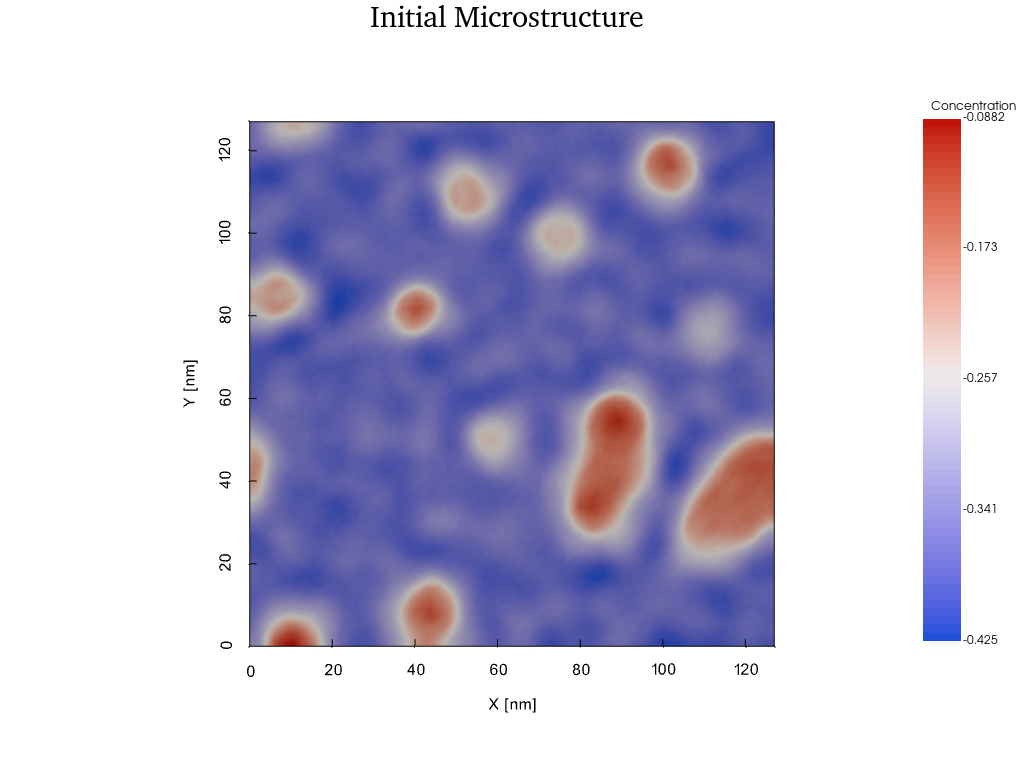

In [65]:
ttime=0
plot_micro(c,"2D",ttime)    

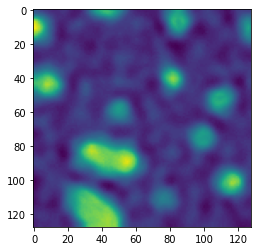

In [83]:
plt.imshow(c)

In [85]:
import matplotlib.pyplot as plt
def show_image(img):
    plt.imshow(np.clip(img + 0.5, 0, 1))
    plt.savefig('img.png')

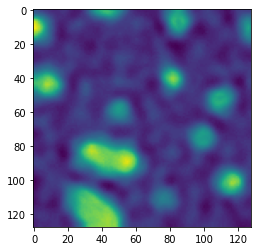

In [86]:
show_image(c)

# Loop on time steps

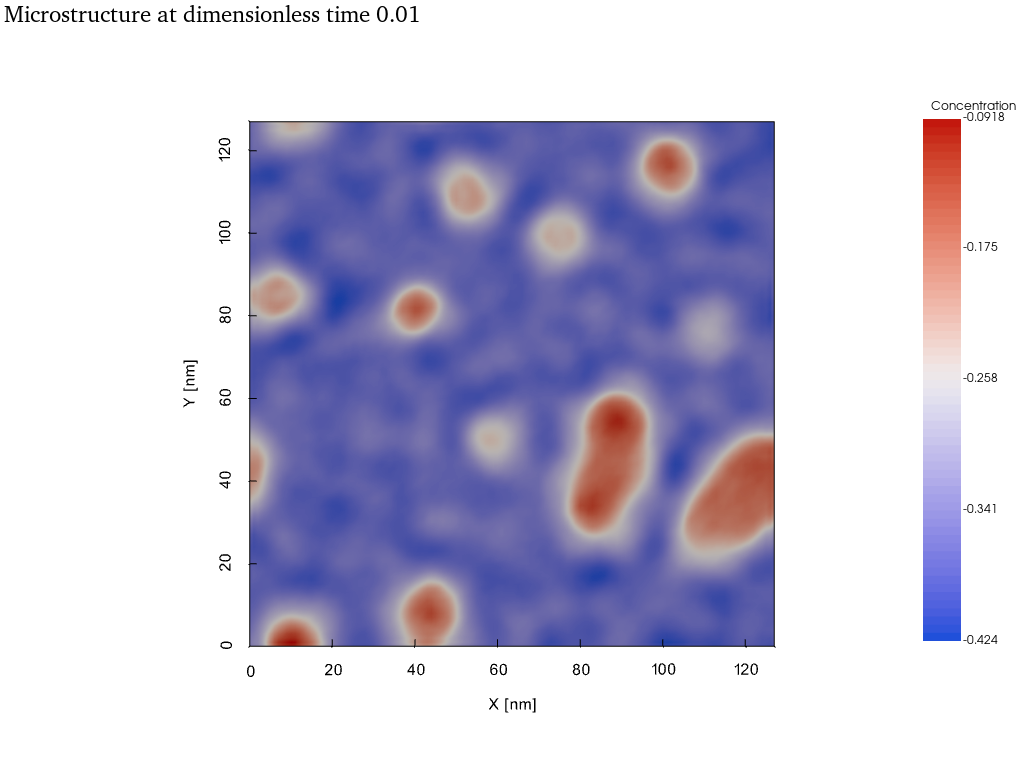

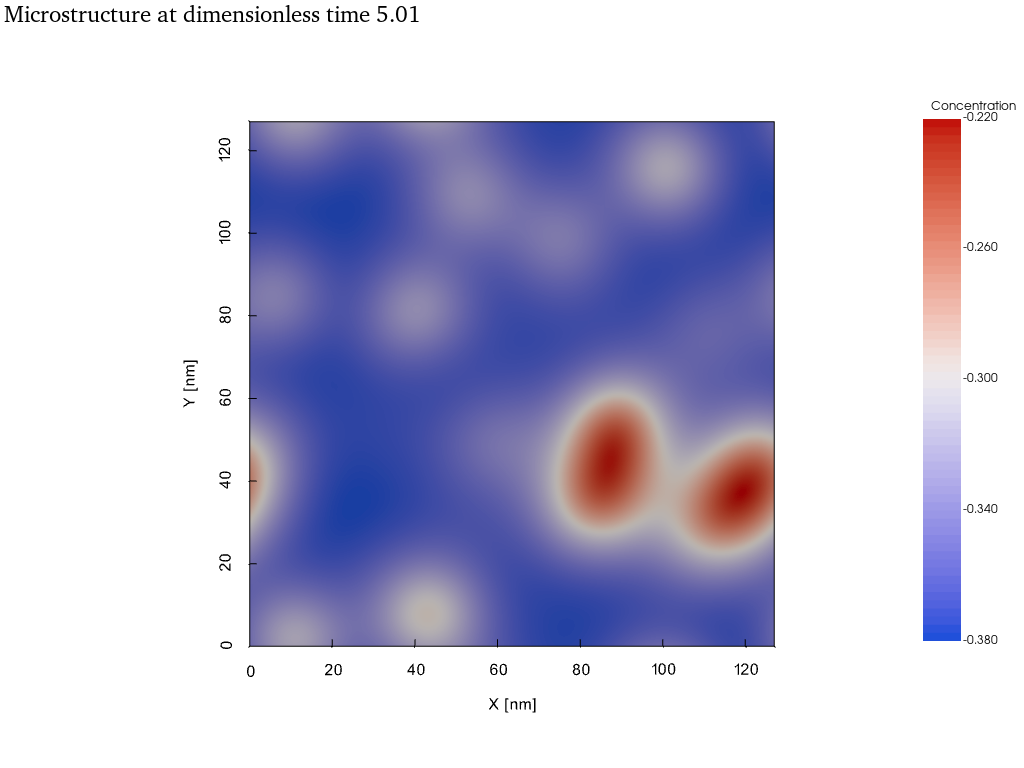

simulation time : 82.47308373451233 seconds ---


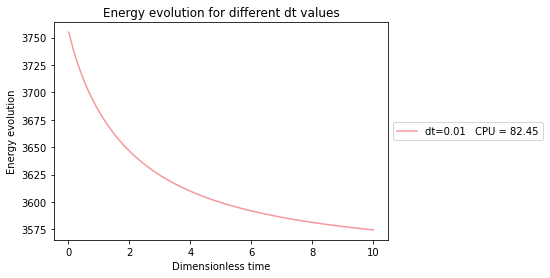

In [79]:
# loop to change time step (dtime) and compute associated energy dissipation for CH equation (at each time step) 
for index in range(len(array_time_steps)):   
    c=c0_save  # take the same microstructure
    # time step and constant values
    ttime=0 # for each simulation 
    dtime=array_time_steps[index]
    #------------------
    # time steps and print parameters
    Nt=10 # trial 
    #nstep=14450 #
    nstep=int(round(Nt/dtime)) #
    nprint=500 # step to print
    # set fourier coefficient 
    # compute the spatial frequency term from fft
    k,k2,k4,x,y,z=prepar_fft(Nx,dx_s,Ny,dy_s,Nz,dz_s,opt="3d")
    dfdc=np.zeros((Nx,Ny,Nz))
    array_energy=[]
    array_time=np.zeros(nstep)  # to save time steps
    array_c=[]
    dfdc=np.zeros((Nx,Ny,Nz))

    # start simulation
    t_start = time.time() 

    endstep=nstep
    flag=0
    #-------------------------------------------------
    for istep in range(nstep):
    #-------------------------------------------------
        if (flag==1):
            endstep=istep
            break #break the loop file
          

        ttime = ttime + dtime  
        array_dtime.append(dtime)
        # compute free energy 
        dfdc=free_energ(c)
            
        dfdck=fft_(dfdc) 
        ck=fft_(c)

        # Time integration
        numer=dtime*mobility*k2*dfdck
        denom = 1.0 + dtime*coefA*mobility*grad_coef*k4
        ck =(ck-numer)/denom
        
        c=np.real(ifft_(ck))   

        # for small deviations
        #c[np.where(c >= 0.9999)]= 0.9999
        #c[np.where(c <= 0.00001)]=0.00001  

        energy=calculate_energ(Nx,Ny,Nz,c,grad_coef)
        array_energy.append(energy)
        array_time[istep]=ttime
        array_c.append(c)
        
        energ = np.array(array_energy)
        """
        if (energ[istep]<50):
            print('break simulation')
            flag=1
        """
        if (math.fmod(istep,nprint)==0):
            #print(istep,energy)
            plot_micro(c,"2D",ttime)
            #plt.imshow(c)
            #plt.show()

        """" 
        if ((math.fmod(int(energ),20)==0):
            plot_micro(c,"2D",ttime)
        """
        
          
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    #-------------------------   Post processing   ------------------------------------
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------        
    # plot energy evolution during spinodal deomposition
    #---------------------------------------------------------------------------------- 
 

    array_time = np.array(array_time)
    rgb = np.random.rand(3,)
    plt.plot(array_time[:endstep] ,energ[:endstep],label = "dt="+str('{0:.2f}'.format(dtime))+"   CPU = "+ str('{0:.2f}'.format(time.time()-t_start)),color =rgb)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title('Energy evolution for dt='+str('{0:.2f}'.format(dtime)))
    plt.xlabel('Dimensionless time')
    plt.ylabel('Energy evolution')
    #plt.show() 
    my_path =""
    #name='Energy evolution for dt='+str('{0:.2f}'.format(dtime)) + ".png"
    #plt.savefig( name)
    plt.title('Energy evolution for different dt values')
 
    #----------------------------------------------------------------------------------        
    #plot solution evolution in space for (y=x)
    #---------------------------------------------------------------------------------- 
    """
    #transform array_time (time steps sauvegarded) from list to array
    array_time=np.array(array_time)
    
    # return index of time of plot (here the end of simulation is chossen)
    time_plot=int(np.array(np.where(abs(array_time - ttime)<0.001)))
    print(time_plot)
    #solution at the choosen instant 
    sol=array_c[time_plot]
    # extract diagonal of the matrix "sol"
    x_y_solution=np.diag(sol)
    plt.xlabel('y=x')
    plt.ylabel('Concentration at the end of simulation')
    rgb = np.random.rand(3,)
    plt.plot(x_y_solution,label = "dt="+str(dtime),color =rgb)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """
    #----------------------------------------------------------------------------------        
    # plot evolution of infinite norm versus time 
    #---------------------------------------------------------------------------------
    """
    infinite_norm=[]
    array_c=np.array(array_c)
    for i in range (1,nstep):
        #compute infinite norm
        c_n=np.max(array_c[i,Nx-1,Ny-1])
        c_n__1=np.max(array_c[i-1,Nx-1,Ny-1])
        infinite_norm.append(abs(c_n-c_n__1))
    infinite_norm=np.array( infinite_norm)  
    rgb = np.random.rand(3,)
    plt.plot(array_time[1:],infinite_norm,label = "dt="+str('{0:.2f}'.format(dtime)),color =rgb)    
    plt.xlabel('t$^{n}$')
    plt.ylabel('||c$^{n}$ - c$^{n-1}$||$_{inf}$')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """
    #print('done istep: ', istep)
CPU=time.time() - t_start
print("simulation time : %s seconds ---" % (time.time() - t_start))

# Postprocess

In [31]:
# save energy_vs_time in txt file : for comparative purposes
np.savetxt('energy_constant_time_stepping.txt',energ[:endstep], fmt=' %.2f')
np.savetxt('time_constant_time_stepping.txt',array_time[:endstep], fmt=' %.2f')

#energ_fd =np.loadtxt("energy_fd.txt",  delimiter=" ", unpack=False)

In [11]:
energ.min()

49.99968825952566

Text(0, 0.5, 'Energy evolution')

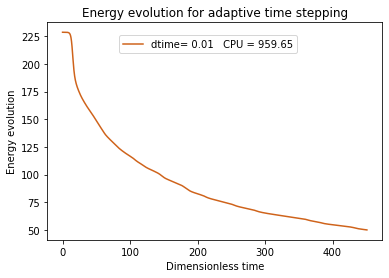

In [12]:
# Energy evolution
energ = np.array(array_energy,)
plt.plot(array_time[:endstep],energ[:endstep],label="dtime= " + str(array_time_steps[0])+"   CPU = "+ str('{0:.2f}'.format(CPU)),color =rgb)
plt.legend(loc='center left', bbox_to_anchor=(0.2, 0.9))
plt.title('Energy evolution for adaptive time stepping')
plt.xlabel('Dimensionless time')
plt.ylabel('Energy evolution')


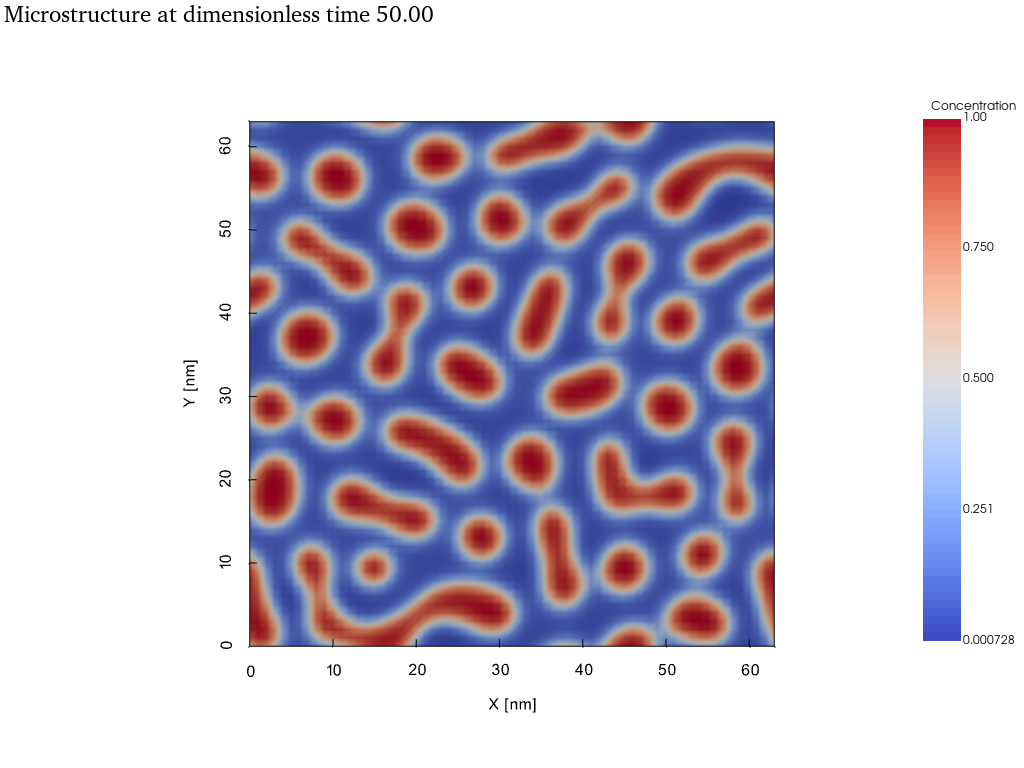

In [25]:
#plot actual microstructure
plot_micro(c,'2D',ttime)

## Compare method 3 and constant time stepping

In [21]:
energ.min()

196.03843478968386

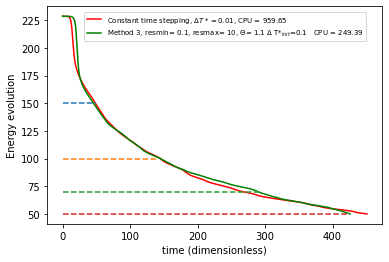

In [16]:
# save energy_vs_time in txt file : for comparative purposes
#np.savetxt('energy_method_2.txt',energ, fmt='%.2f')
#np.savetxt('time_method_2.txt',array_time, fmt=' %.2f')
energ_c =np.loadtxt("energy_constant_time_stepping.txt",   unpack=False)
energ_3 =np.loadtxt("energy_method_3.txt", unpack=False)
time_c =np.loadtxt("time_constant_time_stepping.txt", unpack=False)
time_3 =np.loadtxt("time_method_3.txt", unpack=False)
plt.plot(time_c,energ_c,label = 'Constant time stepping, '+ '$\Delta T*=$'+str(array_time_steps[0])+", CPU = "+ str('{0:.2f}'.format(CPU)),c='r' ) 
plt.plot(time_3,energ_3,label = 'Method 3, '+ 'resmin= '+str(0.1)+ ", "+ 'resmax= '+str(10) + ", "+r'$\Theta$= '+str(1.1)+' $\Delta$ T*$_{init}$='+str(0.1) +"   CPU = "+ str(249.39),c='g')
plt.xlabel('time (dimensionless)')
plt.xlim=(0,500)
plt.ylabel('Energy evolution')
plt.plot([0,50],[150,150],linestyle = '--')
plt.plot([0,140],[100,100],linestyle = '--')
plt.plot([0,295],[70,70],linestyle = '--')
plt.plot([0,425],[50,50],linestyle = '--')

plt.legend( prop={'size': 7},fontsize=20,bbox_to_anchor=(0.1, 0.99))
plt.show()

## save actual microstructure

In [26]:
a_file = open("c1_save.txt", "w")
for row in c[:, :, 0]:
    np.savetxt(a_file, row)

a_file.close()